<!-- <img src="https://www.conted.ox.ac.uk/www/static/images/oudce_logo.svg" alt="OXF_logo_HTML" width="300"> 
-->

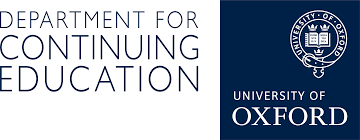 

<h1>Python Programming for Data Science Introduction</h1>
Weekly Oxford Worldwide (WOW) Course Format

<style>
div.scrollable {
    height: 300px;  /* Adjust this value as needed */
    overflow: auto;
    border: 1px solid #ccc;  /* Optional: Adds a border */
    padding: 10px;           /* Optional: Adds padding inside the box */
}
</style>

# Lecture 6 Pandas II

## Plan for this lecture

1. Split, Apply &  Combine 

2. Other techniques such as `filter()`, `transform()`, `agg()`

3. Exercises

In [ ]:
import numpy as np
import pandas as pd

Let's import the movies database again

In [ ]:
imdb_movies = pd.read_csv("../datasets/imdb-movies.csv")
imdb_movies.set_index('Rank', inplace=True)
imdb_movies.shape

In [ ]:
imdb_movies.head()

## Question: 
Which are the most and the least common genres in our dataset?

In [ ]:
genre = imdb_movies.loc[1]['Genre']

In [ ]:
genre

Issue: genre is a comma separated string. We need to convert it to something more useful for our computations

In [ ]:
genres = genre.split(',')
genres

## Exercise: 
Create a new column splitting the genres and saving them as a list

In [ ]:
# complethe this code snippet
imdb_movies['Genres'] = ...

In [ ]:
imdb_movies.head()

In [ ]:
del imdb_movies['Genre']

In [ ]:
imdb_movies.head()

Now the simlplest and most efficient way to count the genre occurrences is to "explode" them, tranforming each element in the `genres` lists into a separate row.

In [ ]:
imdb_movies_unwinded_genres = imdb_movies.explode('Genres').reset_index()
imdb_movies_unwinded_genres

## Exercise 
Count genre occurrences within the dataset. Plot the result as a bar plot. 

In [ ]:
# write the solution here

We can do some extra exploration.
**Challenge:** Let's find the movies with highest revenue over metascore ratio

In [ ]:
# 1. Compute the Revenue / Metascore ratio

revenue_to_metascore_ratio = ...
revenue_to_metascore_ratio

In [ ]:
# 2. Select only some relevant columns and add a "Revenue/Metascore Ratio" column
imdb_movies_sorted_by_ratio = imdb_movies.loc[
    :, ['Title', 'Director', 'Rating', 'Revenue (Millions)']
]
imdb_movies_sorted_by_ratio['Revenue/Metascore Ratio'] = revenue_to_metascore_ratio

In [ ]:
# 3. Sort movies by descending "revenue/metascore ratio"
imdb_movies_sorted_by_ratio.sort_values(
    by='Revenue/Metascore Ratio',
    inplace=True,
    ascending=False
)
imdb_movies_sorted_by_ratio.head()

## Exercise:
Convert the "actors" field into a list and delete the old column

In [ ]:
# write your solution here

## Split, Apply, Combine

In [ ]:
imdb_movies = pd.read_csv("../datasets/imdb-movies.csv")
imdb_movies.set_index('Rank', inplace=True)

In [ ]:
imdb_movies.sample(3)

### Which director generated the highest average income?

The goal of our analysis will be to find which director generated on average more income.
We will have to:

1) split the dataframe according to movie director

2) compute the average income per director

3) combine the results

In [ ]:
# Split
COLUMNS_TO_SELECT = [
    "Runtime (Minutes)",
    "Revenue (Millions)",
    "Rating",
    "Metascore",
    "Director"
]
grouped_by_director = imdb_movies[COLUMNS_TO_SELECT].groupby('Director')
type(grouped_by_director)

In [ ]:
grouped_by_director.describe()

The `groups` attribute is a `dict` whose keys are the computed unique groups and corresponding values being the axis labels belonging to each group. In the above example we have:

In [ ]:
grouped_by_director.groups

In [ ]:
imdb_movies.loc[992]

### Apply and combine phase

After the group-by operation there are a wide range of options for the "apply" phase

1) Aggregations using the `.aggregate()` or `.agg()` method of `DataFrameGroupBy`
    a) as a special case you can use Pandas built-in aggregation methods (`count`, `mean`, etc...)
    
2) Transformations using the `.transform()` method

3) Filtrations using the `.filter()` method

4) A generalisation of the two above using the `.apply()` method

In this case we will have to perform an aggregation.

In [ ]:
### Get the mean value for the three features for each director
grouped_by_director.mean()

Now we have all we need to find the director(s) with the highest average income

In [ ]:
### Write the solution here


## Exercise: 

Find the 10 directors which generated the highest and lowest average income, but filter out directors who have directed less than 3 movies

In [ ]:
imdb_movies.info()

In [ ]:
# write your solution here...


## Other aggregation techniques

With `.agg()` we can get more than one statistics at once

In [ ]:
# Get all the statistics about directors
directors_stats = grouped_by_director.agg([np.mean, np.median, np.std])
directors_stats

In [ ]:
# get all the statistics about Runtime
directors_stats.loc[:, "Runtime (Minutes)"]

In [ ]:
# get all the average Runtime for actor movies
directors_stats.loc[:, "Runtime (Minutes)"]["mean"].sort_values(ascending=False)

It is also possible to compute customised statistics (i.e. write your own functions)

In [ ]:
custom_directors_stats = grouped_by_director.agg([
    lambda x: x.max() - x.min(),
    lambda x: x.mean() - x.median()
])
custom_directors_stats

The issue is that the generated stats do not have meaningful names.

If you want to provide names to the generated columns you need to use the `pd.NamedAgg` construct.

In [ ]:
## Named aggregations

# Get all the statistics about directors
custom_directors_stats = grouped_by_director.agg(
    runtime_min_max_diff=pd.NamedAgg(
        column="Runtime (Minutes)",
        aggfunc=lambda x: x.max() - x.min()
    ),
    runtime_mean_median_diff=pd.NamedAgg(
        column="Runtime (Minutes)",
        aggfunc=lambda x: x.mean() - x.median()
    )
)
custom_directors_stats

### Data Transformation with `.transform()`

The `.transform()` method returns an object that is indexed the same (same size) as the one being grouped. 

#### Which 10 movies have earned more with respect to the average yearly movie revenue of the year they came out?

In [ ]:
COLUMNS_TO_SELECT = [
    "Runtime (Minutes)",
    "Revenue (Millions)",
    "Rating",
    "Metascore",
    "Year"
]
res = imdb_movies[COLUMNS_TO_SELECT].groupby("Year").transform(lambda x: x - x.mean())
res

In [ ]:
# insert the title column at the beginning of the DF
res.insert(loc=0, column='Title', value=imdb_movies['Title'])

# show first 10 movies by mean-normalised revenue, descending
res.sort_values(by="Revenue (Millions)", ascending=False).head(10)

### Filtration with `.filter()`

The filter method returns a subset of the original object.

##### <b>Exercise</b>: get all the movies by Directors whose average rating is higher than 7.5

In [ ]:
# write your solution here


### More generic operations with `.apply()`

The generic `.apply()` method can be used in lieu of either `.aggregate()` and `.transform()` in many standard use cases.

However, apply can handle some exceptional use cases, as in the example below:

In [ ]:
grouped_by_director = imdb_movies.groupby('Director')["Revenue (Millions)"]
type(grouped_by_director)

In [ ]:
def func(group: pd.Series) -> pd.DataFrame:
    return pd.DataFrame({
        'original': group,
        'mean_normalized': group - group.mean(),
        'median_normalized': group - group.median()
    })

grouped_by_director.apply(func)

### Multi-indexing

Lets' suppose we have an experimenyal scenatio with three groups two test groups and one control group.

Each group has three subjects

We will use the group as the first level in our hierarchical index and the subject as the second level.

In [ ]:
index_lists = [
    [
        'control', 'control', 'control', 
        'test_first', 'test_first', 'test_first', 
        'test_second', 'test_second', 'test_second'
    ],
    [
        'subj_0', 'subj_1', 'subj_2',
        'subj_0', 'subj_1', 'subj_2',
        'subj_0', 'subj_1', 'subj_2',
    ]
]
tups = list(zip(*index_lists))
tups

We use `MultiIndex.from_tuples()` to create out hierarchical index

In [ ]:
index = pd.MultiIndex.from_tuples(tups)
index

We simulate to features/variables observed on our subjects using random distributions

In [ ]:
data = np.array([np.random.uniform(120, 180, 9), np.random.uniform(60, 100, 9)]).T
data

In [ ]:
df = pd.DataFrame(
    data=data, 
    columns=['systolic blood pressure', 'diastolic blood pressure'], 
    index=index
)
df

### Computational Tools

There are functions to compute covariance and correlation matrices, similar to the NumPy ones.

In [ ]:
imdb_movies.cov()

In [ ]:
imdb_movies.corr()

The `.rank()` method can be used to rank items inside a group:

In [ ]:
imdb_movies['Most Profitable By Director Rank'] = imdb_movies \
    .groupby('Director')['Revenue (Millions)'] \
    .rank(method='first')

In [ ]:
imdb_movies.sort_values(
    ['Director', 'Most Profitable By Director Rank']
)[['Title', 'Director', 'Revenue (Millions)', 'Most Profitable By Director Rank']].tail(10)